# Introduction

The purpose of this notebook is as follows:
* __Classifier Evaluation:__ use our nested Cross-Validation (nCV) framework to evaluate the performance of different classifiers (Logistic Regression, Gaussian Naive Bayes, k-Nearest Neighbors, Linear Discriminant Analysis, and Support Vector Machines) on our imbalanced dataset and compute a suite of performance metrics (e.g., MCC, Balanced Accuracy, F1, Sensitivity etc.) across multiple iterations of the nCV to determine the median performance of the classifiers and other statistical properties (e.g., 95% Confidence Intervals)
* __Model Optimization and Final Classifier Selection:__ define and tune hyperparameters for each classifier within the inner folds of the nCV using systematic hyperparameter optimization techniques and identify the best-performing classifier based on a purpose-aligned balance of the selected performance metrics over multiple nCV iterations
* __Final Model Training and Deployment:__ after selecting the best classifier, train the final model on the entire dataset using simple cross-validation (5 folds), and save the optimally tuned model to a file for future deployment, ensuring the model is ready to be tested on a new, unseen hold-out dataset

In [ ]:
# Importing all necessary libraries and the NestedCrossValidation class
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, f1_score, fbeta_score, recall_score, precision_score, average_precision_score, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from scipy.stats import bootstrap
import pickle
import optuna
import joblib
import sys
sys.path.insert(1, '/home/giatraskon/DSIT/MLCB2024/Assignment_2_Revised/src')
from nCV_class import NestedCrossValidation
import warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

# The `NestedCrossValidation` Class

The `NestedCrossValidation` class performs repeated nested cross-validation, involving an outer loop for model evaluation and an inner loop for hyperparameter tuning. It preprocesses data by handling missing values, detecting outliers, scaling features, and optionally selecting features and applying PCA. The class optimizes hyperparameters using Optuna, evaluates multiple classifiers (GaussianNB, KNeighborsClassifier, LinearDiscriminantAnalysis, LogisticRegression, SVM) with various performance metrics, and stores results to identify the best-performing model. Finally, it saves the trained model with the optimal hyperparameters.

__Key Components__:
* __Initial Preprocessing__: Reads the dataset, handles missing values, removes duplicates, and addresses outliers.
* __Data Preprocessing__: Scales the features, optionally performs feature selection, and applies PCA.
* __Nested Cross-Validation__: Performs cross-validation, including hyperparameter tuning using Optuna, for each classifier.
* __Model Evaluation__: Calculates various performance metrics for each classifier.
* __Final Model Training__: Trains the best classifier on the entire dataset with the optimal hyperparameters and saves the model.

Parameters of the `NestedCrossValidation` Class:
* `csv_file` (str): Path to the CSV file containing the dataset.
* `outer_folds` (int): Number of folds for the outer loop of cross-validation (default = 5).
* `inner_folds` (int): Number of folds for the inner loop of cross-validation (default = 3).
* `n_iterations` (int): Number of iterations for nested cross-validation (default = 10).
* `random_state` (int): Random seed for reproducibility (default = 42).
* `feature_selection` (bool): Boolean indicating whether to perform feature selection (default = False).
* `n_components` (int): Number of PCA components to retain, if any (default = 3).

Methods in the `NestedCrossValidation` Class:
* `__init__`: Initializes the class with the provided parameters.
* `initial_preprocessing`: Reads and preprocesses the dataset.
* `preprocess_data`: Normalizes the features, applies feature selection, and performs PCA.
* `nested_cross_validation`: Executes nested cross-validation and hyperparameter tuning for each classifier.
* `calculate_metrics`: Calculates various performance metrics for model evaluation.
* `train_final_model`: Trains the final model with the best classifier and hyperparameters and saves it.

# nCV Pipeline Without Feature Selection

Having detailed each component of the pipeline, we are now ready to begin with its implementation. We start by initializing a `NestedCrossValidation` class instance, with the dataset's CSV file and various appropriate parameters for the cross-validation process, including the number of outer and inner folds, the number of iterations, random seed for reproducibility, and options for feature selection (False in this case) and PCA. The `__init__` method also sets up the classifiers and their corresponding hyperparameter spaces, initializes data structures to store results, and generates a list of seeds for each iteration to ensure reproducibility across experiments.

In [3]:
# Initializing a NestedCrossValidation class instance (no feature selection)
ncv_no_fs = NestedCrossValidation(csv_file='../data/Diabetes.csv', n_iterations=10, outer_folds=5, inner_folds=3, random_state=42, feature_selection=False, n_components=3)

We can now use the `nested_cross_validation` method. This method executes the nested cross-validation process:

* The process starts by calling the `initial_preprocessing` method to prepare the dataset. This involves reading the CSV file, setting the index, removing duplicates, filling missing values, and handling outliers to ensure data quality and consistency.
* Next, the `preprocess_data` method is invoked to further preprocess the training and test sets. This includes normalizing the features, applying feature selection (optionally), and performing PCA as necessary to ensure the data is in the optimal format for the classifiers.
* The method then iterates over the specified number of iterations (10) and splits the data into training and test sets for each outer fold. It performs inner cross-validation to optimize hyperparameters for each classifier using Optuna.
* Finally, the method trains the classifiers with the best hyperparameters and evaluates their performance on the test set using the `calculate_metrics method`, storing the results. Metrics include MCC, balanced accuracy, F1 score, F2 score, recall, specificity, precision, average precision, and negative predictive value.

In [4]:
# Performing nested cross-validation (no feature selection)
ncv_no_fs.nested_cross_validation()

Iteration 1/10 with seed 7270
  Outer Fold 1/5
    Evaluating LogisticRegression
    Best params for LogisticRegression: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
    Evaluating GaussianNaiveBayes
    Best params for GaussianNaiveBayes: {'var_smoothing': 1e-07}
    Evaluating k-NearestNeighbors
    Best params for k-NearestNeighbors: {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'euclidean'}
    Evaluating LinearDiscriminantAnalysis
    Best params for LinearDiscriminantAnalysis: {'solver': 'eigen', 'shrinkage': None}
    Evaluating SupportVectorMachine
    Best params for SupportVectorMachine: {'C': 100, 'kernel': 'linear', 'gamma': 'scale'}
  Outer Fold 2/5
    Evaluating LogisticRegression
    Best params for LogisticRegression: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
    Evaluating GaussianNaiveBayes
    Best params for GaussianNaiveBayes: {'var_smoothing': 1e-08}
    Evaluating k-NearestNeighbors
    Best params for k-NearestNeighbors: {'n_neighbors': 11, 

As outlined in the `exploratory_data_analysis.ipynb` notebook, it was found that the classes are imbalanced. Consequently, we will select the model with the highest median Matthews correlation coefficient (MCC) score. 

The Matthews correlation coefficient (MCC) is a performance metric used in machine learning to evaluate the quality of binary classifications. It is especially useful in situations where the classes are imbalanced. The MCC takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The formula for MCC is:

$ \text{MCC} = \frac{TP \times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}, $

where:
* TP is the number of true positives
* TN is the number of true negatives
* FP is the number of false positives
* FN is the number of false negatives

The value of the MCC ranges from -1 to +1:
* +1 indicates a perfect prediction
* 0 indicates a prediction no better than random
* −1 indicates total disagreement between prediction and observation.

Thus, a `get_best_classifier` function is created to compute the median MCC for each classifier, after the 50 cross-validation iterations within the pipeline. It then identifies and selects the classifier that achieves the highest median MCC.

In [23]:
def get_best_classifier(ncv):
    """
    Getting the best classifier based on the median MCC score.

    Parameters:
    - ncv: NestedCrossValidation object containing results for different classifiers.

    Returns:
    - best_clf_name: The name of the best classifier based on the median MCC score.
    """
    median_mcc = {clf_name: np.median([metrics['mcc'] for metrics in metrics_list]) for clf_name, metrics_list in ncv.results.items()} # getting the median MCC score for each classifier
    best_clf_name = max(median_mcc, key=median_mcc.get) # getting the classifier with the highest median MCC score
    print(f"Best classifier based on median MCC: {best_clf_name}") # printing the name of the best classifier
    return best_clf_name # returning the name of the best classifier

# Getting the best classifier based on the median MCC score (no feature selection)
best_clf_name = get_best_classifier(ncv_no_fs) 

Best classifier based on median MCC: LogisticRegression


The top-performing classifier in this case is the __LogisticRegression__.

## <ins> Plotting the Results of the nCV Pipeline Without Feature Selection </ins>

To gain further insight into the scores and model parameters for all classifiers under consideration, graphical visualizations are employed. To this end, we write the following functions that will be used to create plots:

* `plot_mcc_distribution`: This function plots the distribution of the Matthews Correlation Coefficient (MCC) scores for the best classifier in a `NestedCrossValidation` object. It extracts the MCC scores from the nested cross-validation results, creates a histogram with a kernel density estimate (KDE) overlay, and customizes the plot's appearance with appropriate titles, axis labels, and grid lines. This function provides a visual representation of the classifier's performance distribution, which is helpful for evaluating model reliability and variability.
* `plot_heatmap`: This function plots a heatmap of the mean and standard deviation of various classification metrics for each algorithm. It filters out the 'precision_recall_curve' data from the scores list, converts the scores into DataFrames, and computes the mean and standard deviation of the scores. It then creates two subplots: one for the mean scores and one for the standard deviation scores, with appropriate color normalization and annotations. The heatmap visually compares the performance metrics across different classifiers, helping to identify strengths and weaknesses of each algorithm.
* `plot_boxplot`: This function creates a boxplot for each algorithm based on the provided scores, displaying the distribution of classification metrics. It filters out the 'precision_recall_curve' data from the scores list, converts the scores into DataFrames, and plots a boxplot for each algorithm. Each subplot represents an algorithm and shows the distribution of its scores for various metrics. The boxplots provide insights into the variability and central tendency of the performance metrics, facilitating a comparative analysis of the algorithms' performance.

In [36]:
def plot_mcc_distribution(ncv, best_clf_name):
    """
    Plotting the MCC score distribution of the best classifier.

    Parameters:
        ncv (NestedCrossValidation): The NestedCrossValidation object.
        best_clf_name (str): The name of the best classifier.
    """
    scores_list = [metrics['mcc'] for metrics in ncv.results[best_clf_name]] # getting the MCC scores for the best classifier
    # Plotting the MCC score distribution
    plt.figure(figsize=(10, 10))
    plt.title(f"MCC Score Distribution of the {best_clf_name} classifier") # setting the title
    ax = sns.histplot(scores_list, kde=True, bins=10) # plotting the histogram
    plt.xticks(np.arange(0.0, 1.1, 0.1)) # setting the xticks
    ax.set_axisbelow(True) # setting the axis below
    plt.grid(linestyle='--', linewidth='0.5') # setting the grid
    plt.show()

def plot_heatmap(algo_names, scores_list, title):
    """
    Plotting a heatmap of the mean and standard deviation of the scores for each algorithm.

    Parameters:
        algo_names (list): A list of strings representing the names of the algorithms.
        scores_list (list): A list of dictionaries, where each dictionary contains the scores for each algorithm.
        title (str): The title of the plot.
    """
    # Filtering out precision_recall_curve from scores_list
    filtered_scores_list = [{k: v for k, v in metrics.items() if k != 'precision_recall_curve'} for metrics in scores_list]

    # Converting scores to DataFrame
    df_scores_list = [pd.DataFrame(scores) for scores in filtered_scores_list]

    # Computing mean and standard deviation of scores
    mean_scores = np.array([df.mean(axis=0) for df in df_scores_list])
    stdv_scores = np.array([df.std(axis=0) for df in df_scores_list])
    
    # Plotting heatmaps
    fig, ax = plt.subplots(1, 2, figsize=(15, 8), dpi=130, sharey='all') # creating a figure with two subplots
    cmap = plt.get_cmap('rocket') # defining the colormap
    norm_mean = Normalize(vmin=mean_scores.min(), vmax=mean_scores.max()) # normalizing the mean scores
    norm_std = Normalize(vmin=stdv_scores.min(), vmax=stdv_scores.max()) # normalizing the standard deviation scores
    heatmap1 = ax[0].imshow(mean_scores, cmap=cmap, norm=norm_mean, aspect='auto') # plotting the mean scores
    heatmap2 = ax[1].imshow(stdv_scores, cmap=cmap, norm=norm_std, aspect='auto') # plotting the standard deviation scores
    # Adding colobars to the subplots
    plt.colorbar(heatmap1, ax=ax[0], fraction=0.046, pad=0.04) 
    plt.colorbar(heatmap2, ax=ax[1], fraction=0.046, pad=0.04)
    # Adding text annotations to the subplots
    for i in range(mean_scores.shape[0]):
        for j in range(mean_scores.shape[1]):
            ax[0].text(j, i, f'{mean_scores[i, j]:.3f}', ha='center', va='center', color='white')
            ax[1].text(j, i, f'{stdv_scores[i, j]:.3f}', ha='center', va='center', color='white')
    ax[0].set_yticks(np.arange(len(algo_names))) # setting the yticks
    ax[0].set_yticklabels(algo_names) # setting the yticklabels
    # Setting the xticks and xticklabels
    for i in range(2):
        ax[i].set_xticks(np.arange(mean_scores.shape[1])) # setting the xticks
        ax[i].set_xticklabels(df_scores_list[0].columns, rotation=90) # setting the xticklabels
    fig.suptitle(title, fontsize=20) # setting the title
    fig.supxlabel("\nClassification Metric") # setting the xlabel
    fig.supylabel("Classifier Category\n") # setting the ylabel
    plt.tight_layout()
    plt.show()

def plot_boxplot(algo_names, scores_list, title):
    """
    Plotting a boxplot for each algorithm based on the scores provided.

    Parameters:
        algo_names (list): A list of strings representing the names of the algorithms.
        scores_list (list): A list of dictionaries containing the scores for each algorithm.
        title (str): The title of the plot.
    """
    # Filtering out precision_recall_curve from scores_list
    filtered_scores_list = [{k: v for k, v in metrics.items() if k != 'precision_recall_curve'} for metrics in scores_list]

    # Converting scores to DataFrame
    df_scores_list = [pd.DataFrame(scores) for scores in filtered_scores_list]
    
    # Plotting boxplots
    fig, axs = plt.subplots(1, len(algo_names), figsize=(20, 10), sharex=True, sharey=True, constrained_layout=True) # creating a figure with one subplot per algorithm
    axs = axs.flatten() # flattening the axes array
    # Iterating over the scores and algorithm names
    for i, (scores, name) in enumerate(zip(df_scores_list, algo_names)): 
        sns.boxplot(data=scores, ax=axs[i]) 
        axs[i].set_title(name) # setting the title
        axs[i].grid(True, linestyle='--', linewidth='0.5') # setting the grid
        axs[i].set_axisbelow(True) # setting the axis below
        axs[i].set_yticks(np.arange(0, 1.1, 0.1)) # setting the yticks
        axs[i].tick_params(axis='x', rotation=90) # setting the xticks
    fig.supxlabel("\nClassification Metric") # setting the xlabel
    fig.supylabel("Score Distribution\n") # setting the ylabel
    fig.suptitle(title, fontsize=20) # setting the title
    plt.show()

We start by plotting the MCC score distribution of the LogisticRegression classifier.

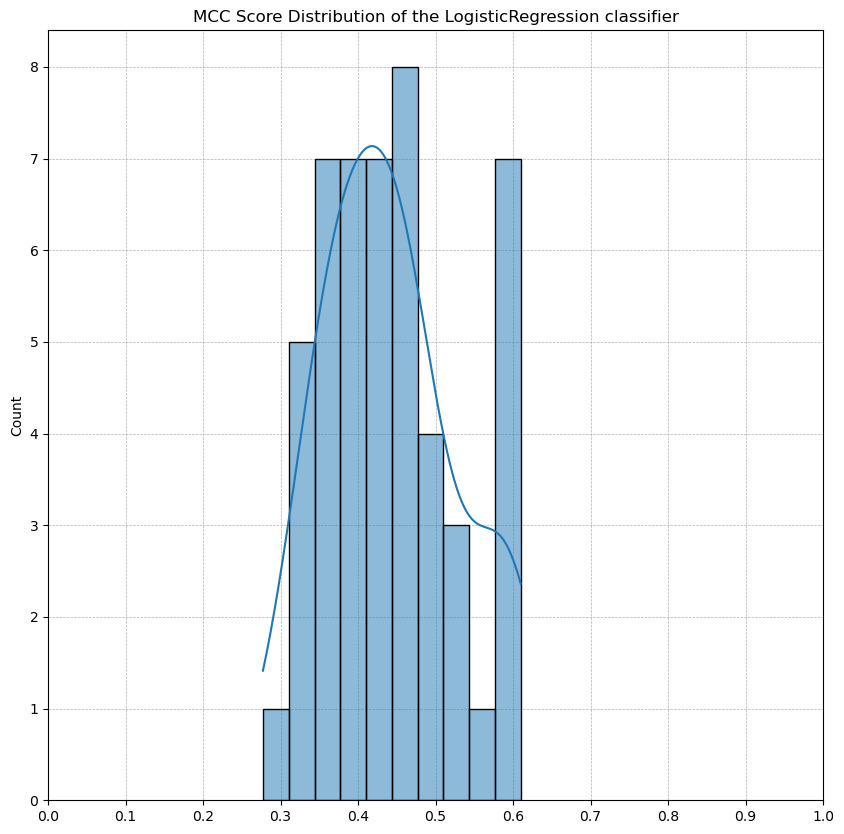

In [33]:
# Plotting MCC score distribution of the best classifier (no feature selection)
plot_mcc_distribution(ncv_no_fs, best_clf_name)

The distribution appears to be somewhat symmetric around the median, with a slight concentration of scores on the right-hand side of the peak. This indicates that there's a moderate inclination for scores to cluster above the median, suggesting better-than-average classifier performance more frequently than not.

In [8]:
# Preparing data for heatmap and box plot (no feature selection)
algo_names = list(ncv_no_fs.classifiers.keys()) # getting the names of the classifiers
scores_list = [pd.DataFrame([metrics for metrics in ncv_no_fs.results[clf_name]]) for clf_name in algo_names] # getting the scores for each classifier

Moving on, the heatmap visually simplifies the understanding of each classifier's performance metrics in the scores list.

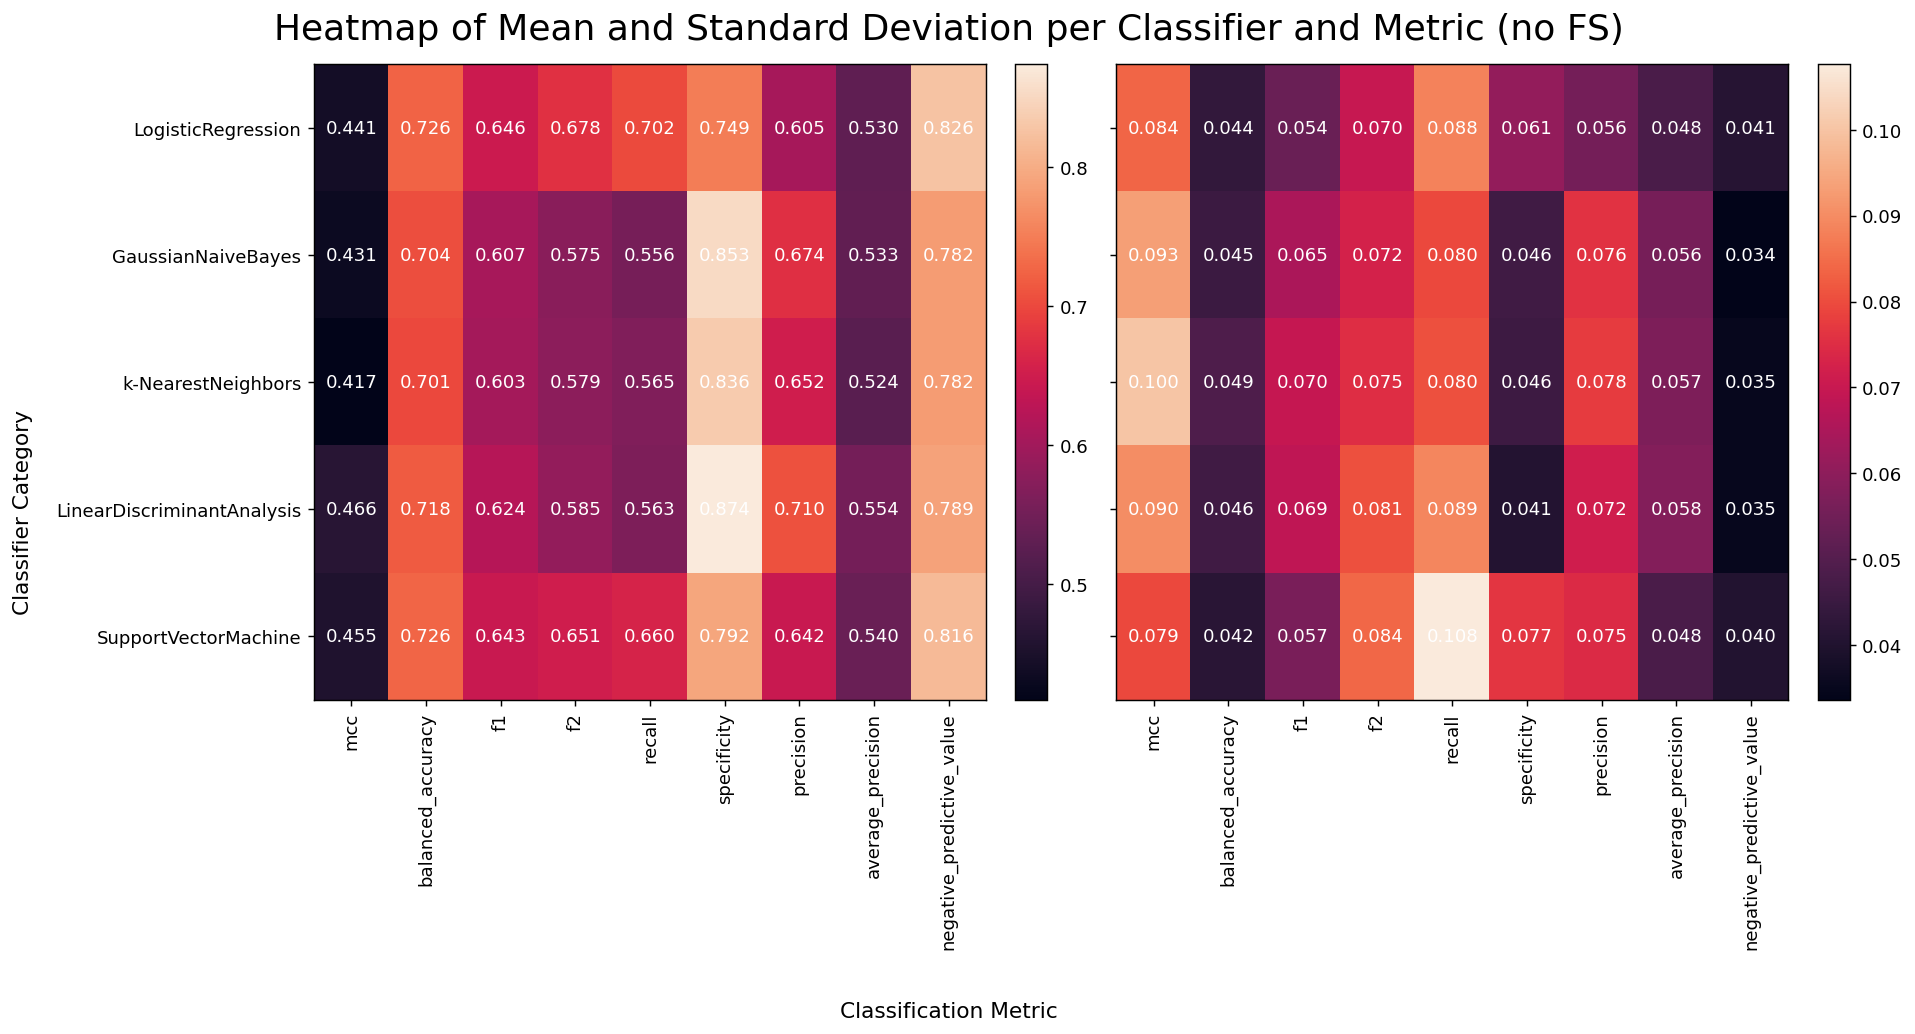

In [37]:
# Plotting heatmap of mean and standard deviation (no feature selection)
plot_heatmap(algo_names, scores_list, "Heatmap of Mean and Standard Deviation per Classifier and Metric (no FS)")

Here, we observe that the best classifier __LogisticRegression__  achieved a median MCC score of 0.442 over 50 CV iterations, with a standard deviation of 0.087.

A more nuanced visualization of data distributions can be achieved using a box plot. In this representation, the box delineates the interquartile range, while the whiskers extend to cover data points within 1.5 times the interquartile range from the quartiles. Boxplots are adept at highlighting the data's median, distribution symmetry, and outliers, making them especially valuable for contrasting distributions across different groups.

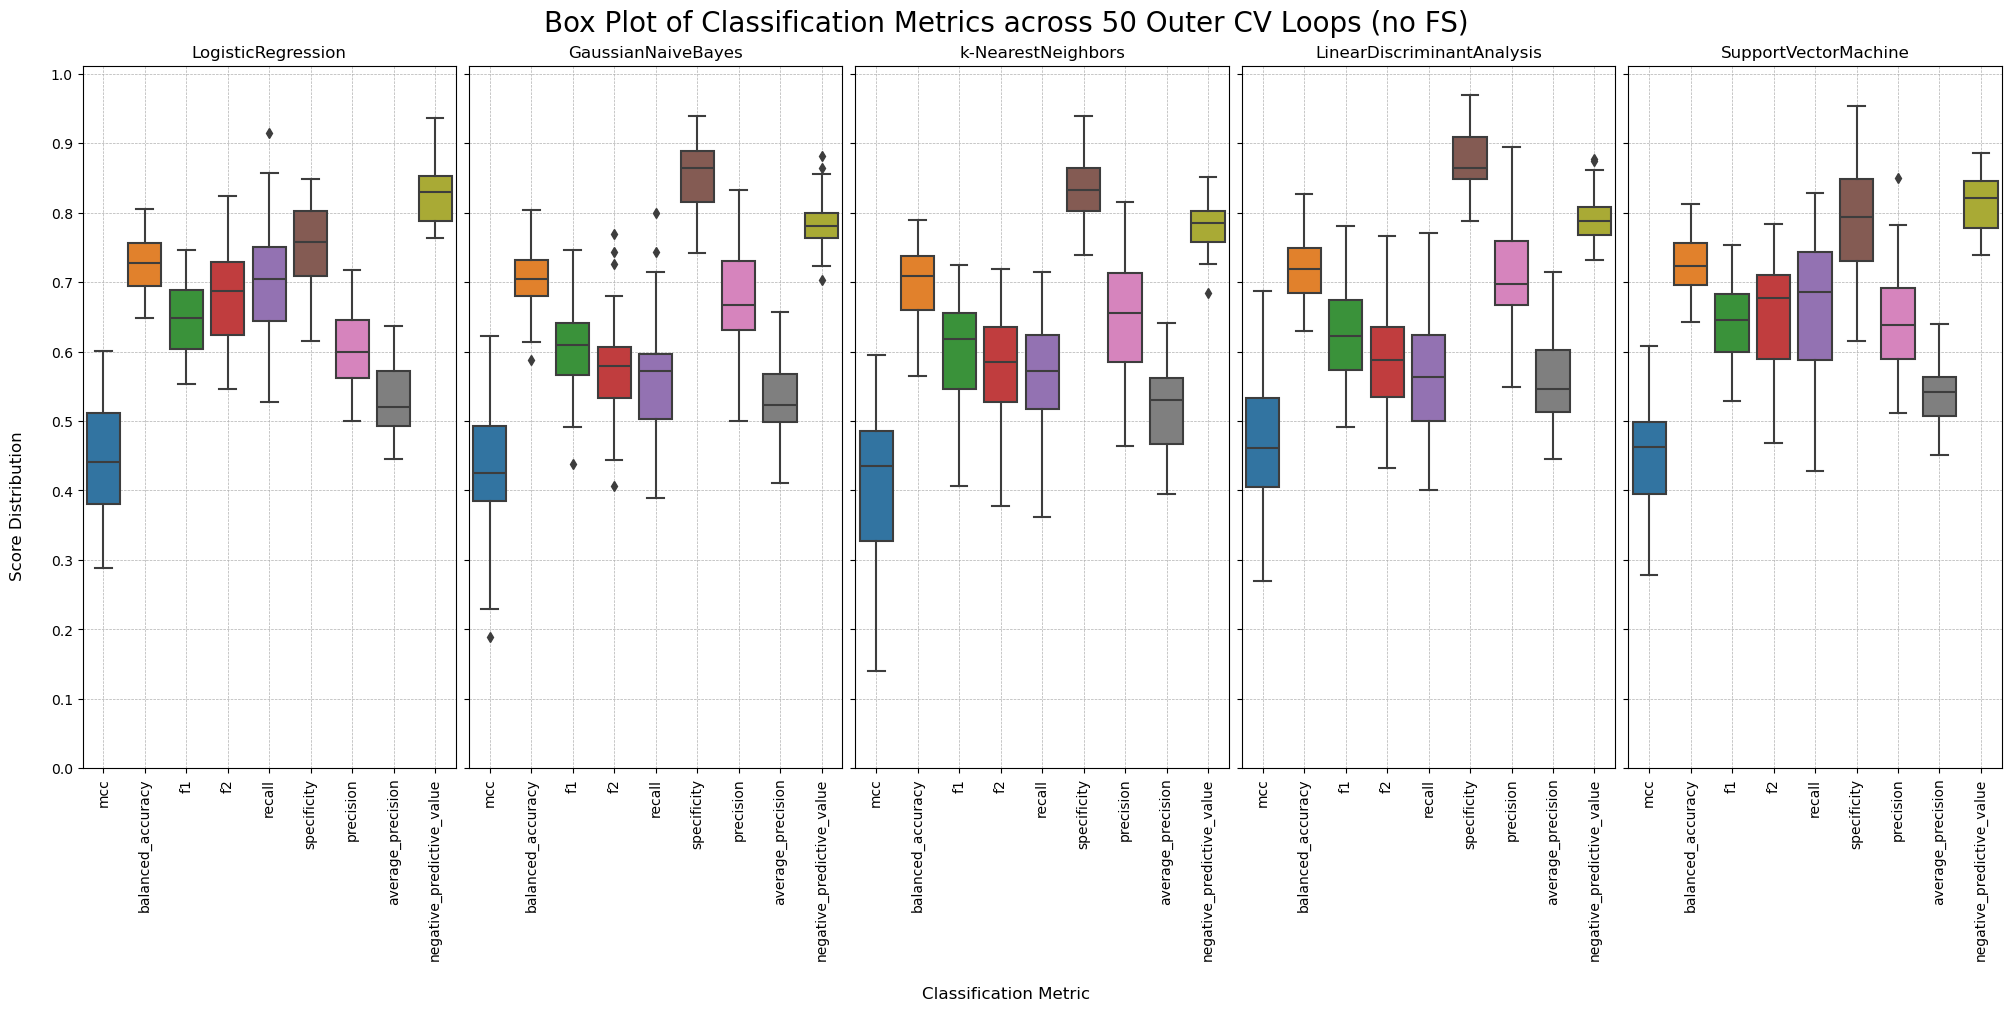

In [38]:
# Plotting boxplot of classification metrics (no feature selection)
plot_boxplot(algo_names, scores_list, "Box Plot of Classification Metrics across 50 Outer CV Loops (no FS)")

Now that we have our best performing algorithm, we will utilize the `train_final_model` method. This method trains the final model using the best classifier identified through the nested cross-validation process. It performs initial preprocessing, optimizes the classifier's hyperparameters using Optuna, and trains the classifier on the entire dataset. The final trained model is then saved to a specified path.

In [11]:
# Training the final model using the best classifier (no feature selection)
ncv_no_fs.train_final_model(best_clf_name)

Final model saved to ../models/LogisticRegression_noFS_PCA3_final_model.pkl


# nCV Pipeline With Feature Selection using Mutual Information

In this pipeline, the feature selection process is performed using the `SelectKBest` method with `mutual_info_classif` as the scoring function, provided that `feature_selection` is set to True when initializing the `NestedCrossValidation` class. The rest of the pipeline is identical.

Feature selection with `SelectKBest` is a method in scikit-learn that selects the top k features based on a specified scoring function. In this context, the scoring function used is `mutual_info_classif`, which measures the mutual information (MI) between each feature and the target variable. Mutual information quantifies the dependency between two variables, providing a non-negative value that is zero if and only if the variables are independent. Higher MI values indicate a higher dependency. This method is particularly beneficial for capturing any kind of dependency between variables, not just linear relationships, thus helping in identifying the features that provide the most information about the target variable.

In practice, the `preprocess_data` method uses `SelectKBest` for feature selection if the attribute `self.feature_selection` is set to True. This involves creating an instance of `SelectKBest` with `mutual_info_classif` as the scoring function and selecting the top 5 features (k=5). The feature selection is then applied to the training data using `selector.fit_transform(X_train_scaled, y_train)`, and the same transformation is applied to the test data using `selector.transform(X_test_scaled)`. This process reduces the feature set to the most informative ones, potentially improving the model’s performance by eliminating irrelevant or redundant features, thereby enhancing the model's efficiency and accuracy.

In [45]:
# Initializing the NestedCrossValidation class (top 5 features)
ncv_fs = NestedCrossValidation(csv_file='../data/Diabetes.csv', n_iterations=10, outer_folds=5, inner_folds=3, random_state=42, feature_selection=True, n_components=3)

In [46]:
# Performing nested cross-validation (top 5 features)
ncv_fs.nested_cross_validation()

Iteration 1/10 with seed 7270
  Outer Fold 1/5
Selected features: ['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'Age']
    Evaluating LogisticRegression
    Best params for LogisticRegression: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
    Evaluating GaussianNaiveBayes
    Best params for GaussianNaiveBayes: {'var_smoothing': 1e-08}
    Evaluating k-NearestNeighbors
    Best params for k-NearestNeighbors: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan'}
    Evaluating LinearDiscriminantAnalysis
    Best params for LinearDiscriminantAnalysis: {'solver': 'eigen', 'shrinkage': 0.1}
    Evaluating SupportVectorMachine
    Best params for SupportVectorMachine: {'C': 100, 'kernel': 'rbf', 'gamma': 'auto'}
  Outer Fold 2/5
Selected features: ['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'Age']
    Evaluating LogisticRegression
    Best params for LogisticRegression: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
    Evaluating GaussianNaiveBayes
    Best params for G

In [44]:
# Getting the best classifier based on the median MCC score (top 5 features)
best_clf_name = get_best_classifier(ncv_fs)

Best classifier based on median MCC: SupportVectorMachine


The top-performing classifier in this case is the __SupportVectorMachine__.

## <ins> Plotting the Results of the nCV Pipeline With Feature Selection using Mutual Information </ins>

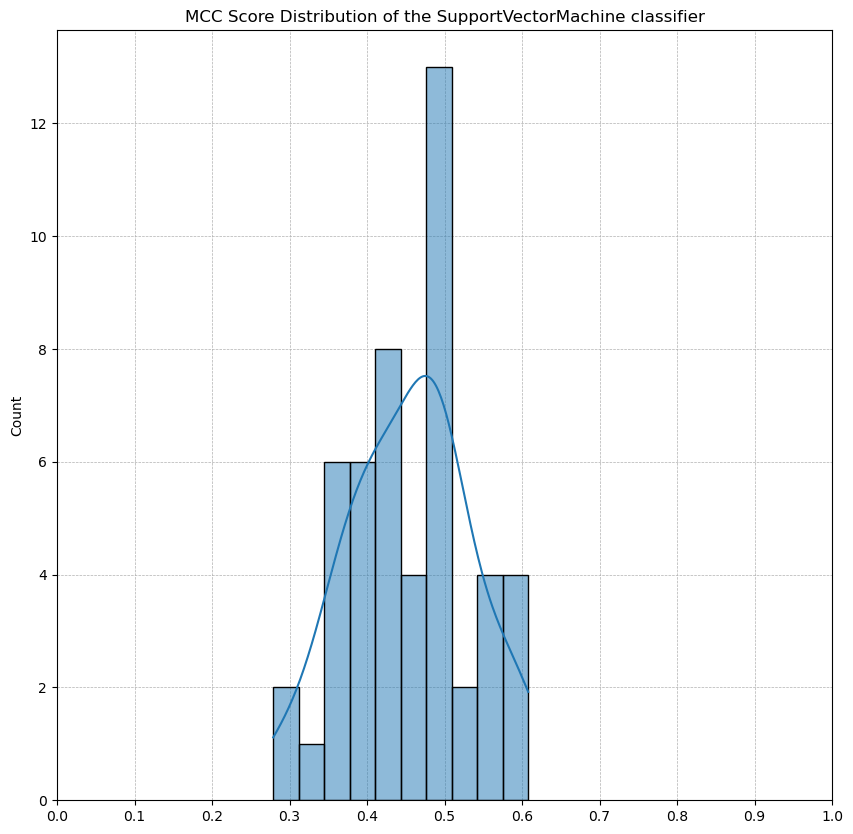

In [40]:
# Plotting MCC score distribution of the best classifier (top 5 features)
plot_mcc_distribution(ncv_fs, best_clf_name)

Similarly to before, the distribution appears to be symmetric around the median, with a slight inclination for scores to cluster above it.

In [41]:
# Preparing data for heatmap and box plot (top 5 features)
algo_names = list(ncv_fs.classifiers.keys())
scores_list = [pd.DataFrame([metrics for metrics in ncv_fs.results[clf_name]]) for clf_name in algo_names]

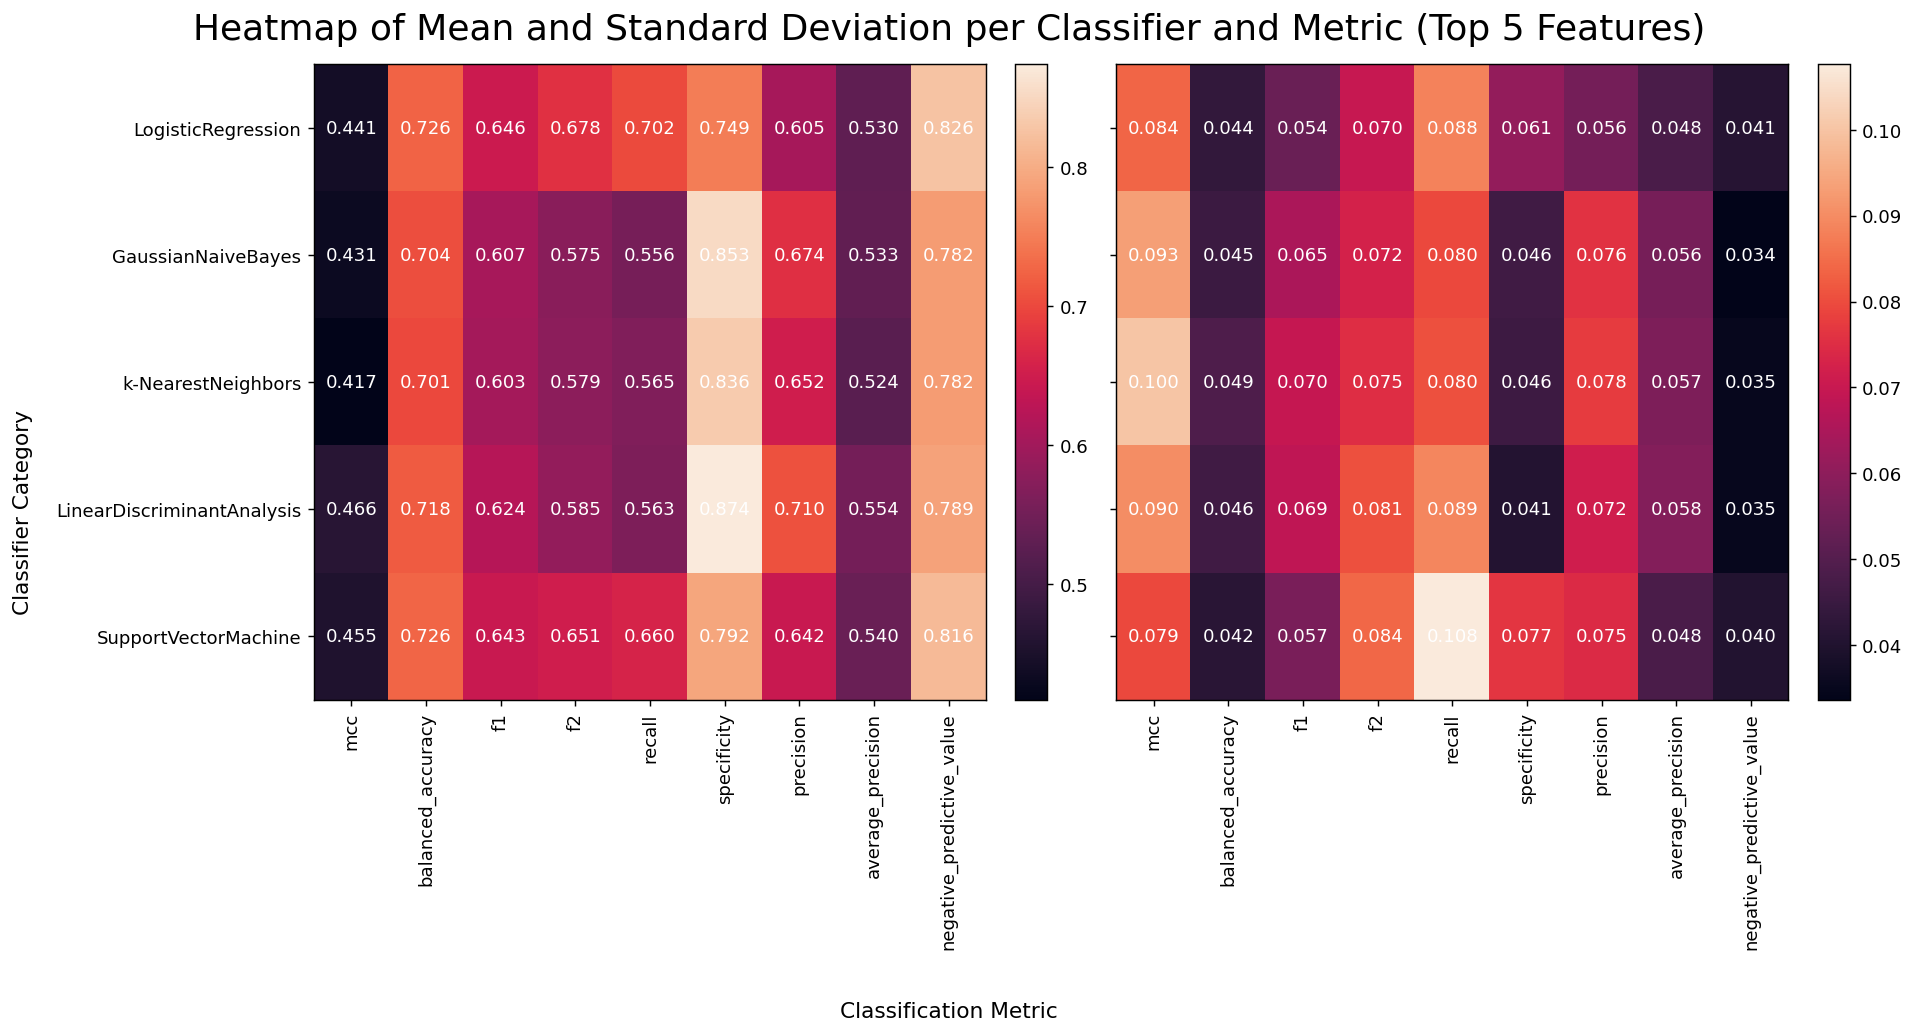

In [42]:
# Plotting heatmap of mean and standard deviation (top 5 features)
plot_heatmap(algo_names, scores_list, "Heatmap of Mean and Standard Deviation per Classifier and Metric (Top 5 Features)")

Here, we observe that the best classifier __SupportVectorMachine__  achieved a median MCC score of 0.455 over 50 CV iterations, with a standard deviation of 0.079.

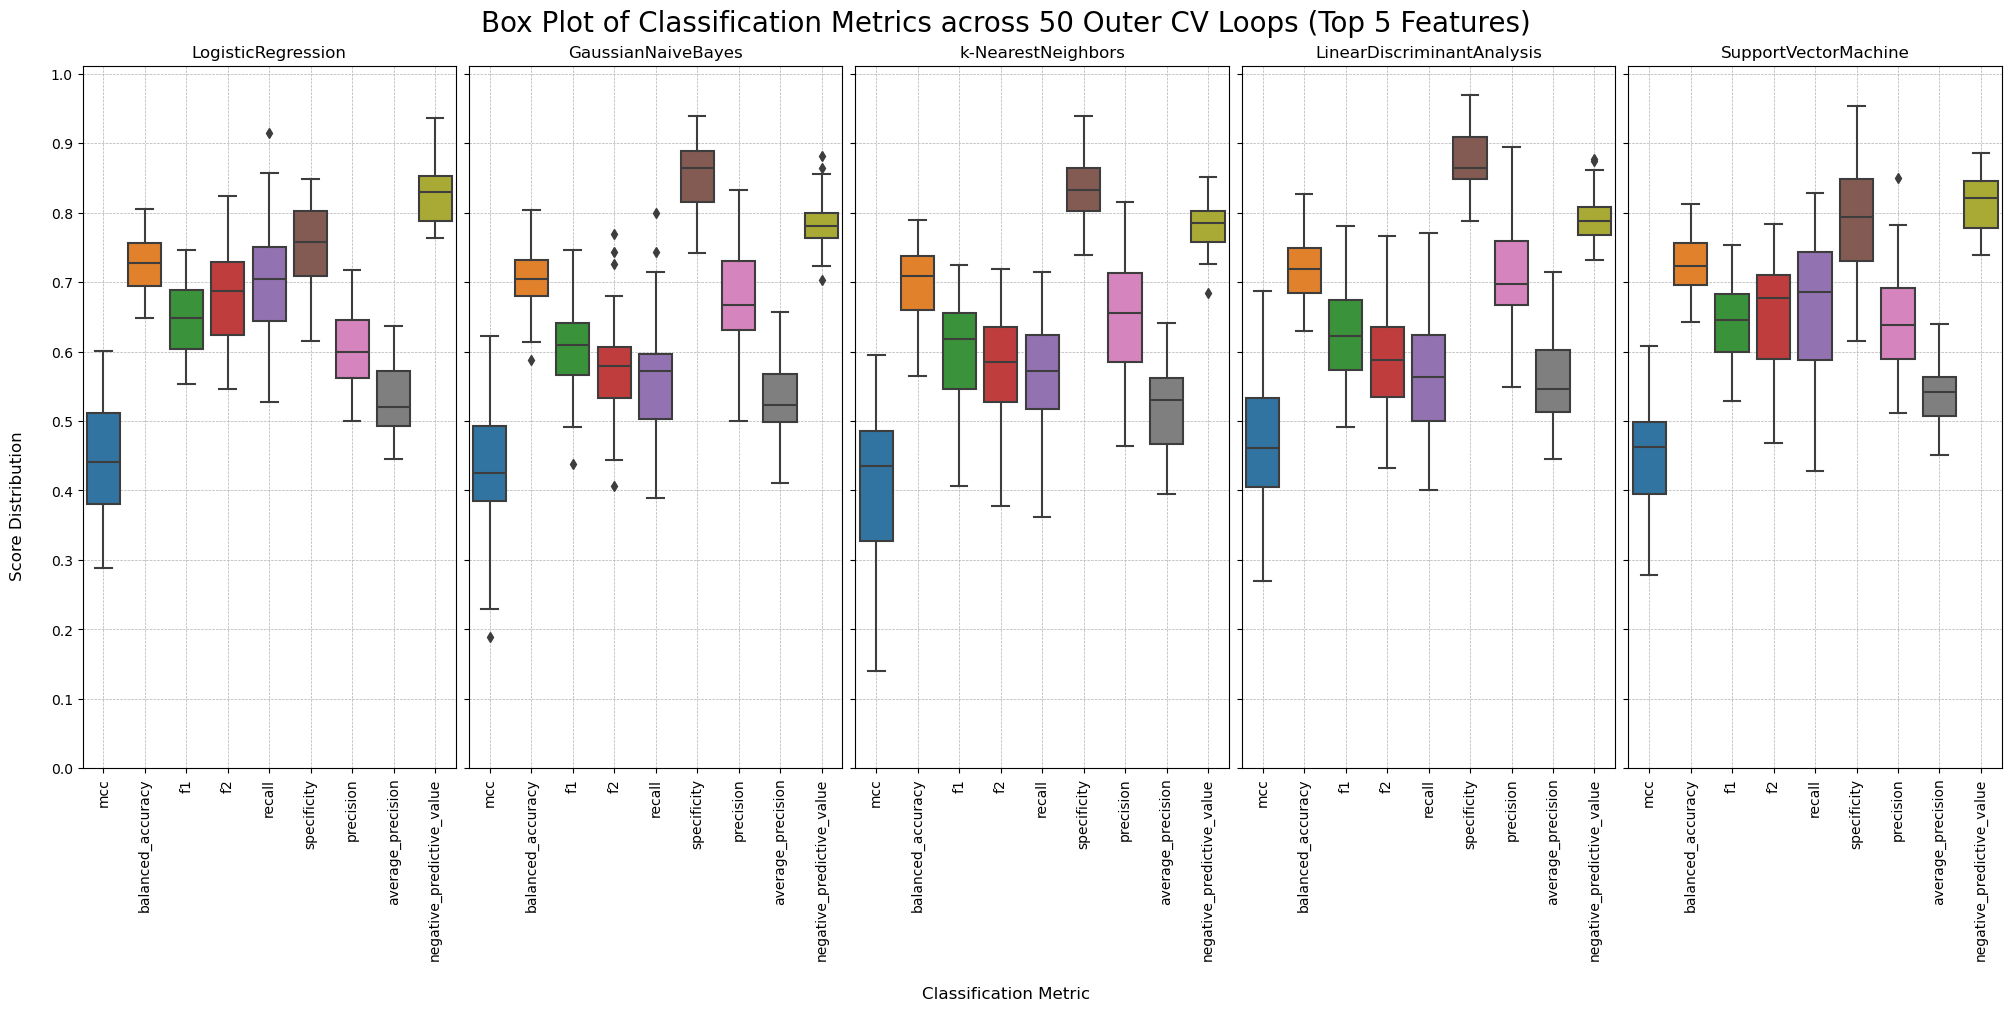

In [43]:
# Plotting boxplot of classification metrics (top 5 features)
plot_boxplot(algo_names, scores_list, "Box Plot of Classification Metrics across 50 Outer CV Loops (Top 5 Features)")

In [19]:
# Training the final model using the best classifier (top 5 features)
ncv_fs.train_final_model(best_clf_name)

Selected features: ['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'Age']
Selected features: ['Glucose', 'BloodPressure', 'Insulin', 'BMI', 'Age']
Selected features: ['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'Age']
Selected features: ['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'Age']
Selected features: ['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'Age']
Selected features: ['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'Age']
Selected features: ['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'Age']
Selected features: ['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'Age']
Selected features: ['Glucose', 'BloodPressure', 'Insulin', 'BMI', 'Age']
Selected features: ['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'Age']
Selected features: ['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'Age']
Selected features: ['Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Selected features: ['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI']
Selected features: ['Pregnancies', 'Glucose', 'Ins

# Results Comparison and Final Model Selection

We can see that the median performaces of our two models from the two pipelines are quite similar (LogisticRegression: median MCC = 0.442, median std = 0.087 | SupportVectorMachine: median MCC = 0.455, median std = 0.079). In this case, we will consider the 95% confidence interval of the medians to declare a "winner" classifier.

Our implementation of the 95% confidence interval for the final classifier selection follows a structured approach involving nested cross-validation results and bootstrapping. It begins by defining a function `calculate_confidence_interval` which calculates the confidence interval for the median of given data points, such as MCC (Matthews Correlation Coefficient) scores. This is achieved through bootstrapping, a resampling method that generates multiple samples from the data to estimate the distribution of the median. The function takes in the data and a confidence level (default is 0.95) and returns the lower and upper bounds of the confidence interval.

In [20]:
def calculate_confidence_interval(data, confidence_level=0.95):
    """
    Calculating the confidence interval for the median using bootstrapping.

    Parameters:
    - data: List or numpy array of data points (e.g., MCC scores).
    - confidence_level: The confidence level for the CI (default: 0.95).

    Returns:
    - lower_bound: The lower bound of the confidence interval.
    - upper_bound: The upper bound of the confidence interval.
    """
    # Converting data to a numpy array
    data = np.array(data)
    
    # Calculating the bootstrap confidence interval for the median
    res = bootstrap((data,), np.median, confidence_level=confidence_level, n_resamples=10000, method='percentile')
    
    return res.confidence_interval # returning the confidence interval

The implementation then defines another function `get_mcc_scores` to extract MCC scores from the nested cross-validation results for different classifiers. It collects MCC scores for scenarios with and without feature selection, stored in `mcc_scores_no_fs` and `mcc_scores_fs`, respectively.

Next, it calculates the 95% confidence intervals for the median MCC scores of each classifier in both scenarios using the previously defined `calculate_confidence_interval` function. The results are stored in dictionaries `ci_no_fs` and `ci_fs`. The confidence intervals are then printed out for both scenarios.

In [21]:
def get_mcc_scores(ncv):
    """
    Getting MCC scores from the nested cross-validation results.

    Parameters:
        ncv (NestedCrossValidation): The NestedCrossValidation object containing the results.

    Returns:
        dict: A dictionary where the keys are the classifier names and the values are lists of MCC scores.
    """
    mcc_scores = {clf_name: [metrics['mcc'] for metrics in metrics_list] for clf_name, metrics_list in ncv.results.items()} # getting the MCC scores from the nested cross-validation results
    return mcc_scores # returning the MCC scores

# Getting the MCC scores for both feature selection scenarios
mcc_scores_no_fs = get_mcc_scores(ncv_no_fs)
mcc_scores_fs = get_mcc_scores(ncv_fs)

# Calculating the 95% CI for the median MCC scores for each classifier in both feature selection scenarios
ci_no_fs = {clf: calculate_confidence_interval(scores) for clf, scores in mcc_scores_no_fs.items()}
ci_fs = {clf: calculate_confidence_interval(scores) for clf, scores in mcc_scores_fs.items()}

# Printing the 95% CIs for the median MCC scores for each classifier in both feature selection scenarios
print("95% Confidence Intervals for median MCC scores (no feature selection):")
for clf, ci in ci_no_fs.items():
    print(f"{clf}: {ci.low:.4f} - {ci.high:.4f}")

print("\n95% Confidence Intervals for median MCC scores (with feature selection):")
for clf, ci in ci_fs.items():
    print(f"{clf}: {ci.low:.4f} - {ci.high:.4f}")

95% Confidence Intervals for median MCC scores (no feature selection):
LogisticRegression: 0.3977 - 0.4619
GaussianNaiveBayes: 0.3917 - 0.4487
k-NearestNeighbors: 0.3538 - 0.4129
LinearDiscriminantAnalysis: 0.3973 - 0.4642
SupportVectorMachine: 0.3846 - 0.4346

95% Confidence Intervals for median MCC scores (with feature selection):
LogisticRegression: 0.3962 - 0.4793
GaussianNaiveBayes: 0.4072 - 0.4576
k-NearestNeighbors: 0.4017 - 0.4651
LinearDiscriminantAnalysis: 0.4230 - 0.4980
SupportVectorMachine: 0.4285 - 0.4886


Finally, the implementation includes a function `compare_confidence_intervals` to compare these intervals. It checks for significant differences between the performance of classifiers with and without feature selection by seeing if one confidence interval entirely lies above or below the other. If a significant difference is found, it identifies the best-performing classifier. Otherwise, it notes that no significant difference exists. The best classifier, if determined, is printed at the end. This approach helps in robustly selecting the final classifier by providing statistical evidence of performance differences.

In [22]:
# Compare the intervals to select the best classifier
def compare_confidence_intervals(ci_no_fs, ci_fs):
    best_classifier = None
    significant_difference = False

    for clf in ci_no_fs.keys():
        if ci_fs[clf].high < ci_no_fs[clf].low:
            best_classifier = clf
            significant_difference = True
            print(f"Classifier without feature selection ({clf}) performs significantly better.")
        elif ci_no_fs[clf].high < ci_fs[clf].low:
            best_classifier = clf
            significant_difference = True
            print(f"Classifier with feature selection ({clf}) performs significantly better.")

    if not significant_difference:
        print("There is no significant difference between the classifiers.")

    return best_classifier

best_classifier = compare_confidence_intervals(ci_no_fs, ci_fs)

if best_classifier:
    print(f"The best classifier is: {best_classifier}")
else:
    print("No best classifier could be determined based on the confidence intervals.")

There is no significant difference between the classifiers.
No best classifier could be determined based on the confidence intervals.


Since no best classifier could be determined based on the confidence intervals, we will simply select the `SupportVectorMachine_FS_PCA3_final_model.pkl` model as the better one, because of its slightly higher median MCC score and slightly lower median standard deviation. This model is located in the `final_model` subdirectory, inside the `models` directory.